In [1]:
import numpy as np
import dapy.filters as filters
import dapy.utils.pou as pou
from dapy.models.damped_advection import SpatialDampedAdvectionModel
from dapy.utils.plotting import (
    plot_rank_histogram, 
    animate_2d_fields, 
    plot_slices_through_time, 
    plot_slices_through_space
)
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['animation.html'] = 'html5'

In [2]:
model_params = {
    'spatial_mesh_shape': (50, 50),
    'time_step': 1.,
    'observation_grid_shape': (10, 10),
    'domain_size': (1., 1.),
    'state_noise_length_scale': 0.0707,
    'state_noise_amplitude': 5.,
    'advection_coeff': (0.0625, 0.0625),
    'damping_coeff': np.log(2) / 2,
    'observation_noise_std': 1.,
    'observation_function': lambda x, t: x / np.tanh(x * 10)
}
model = SpatialDampedAdvectionModel(**model_params)

In [4]:
observation_time_indices = np.arange(0, 2000)
seed = 20220302
rng = np.random.default_rng(seed)
state_sequence, observation_sequence = model.sample_state_and_observation_sequences(
    rng, observation_time_indices, return_states_at_all_times=False
)

Sampling: 100%|██████████|2000/2000 [00:04<00:00, 458.61time-steps/s]

In [5]:
num_particle = 100

In [6]:
localisation_radius = 0.2
ensemble_filter = filters.ScalableLocalEnsembleTransformParticleFilter(
    localisation_radius=localisation_radius, 
    partition_of_unity=pou.SmoothedBlock2dPartitionOfUnityBasis(
        model, (10, 10), kernel_halfwidth=3, use_distance_from_patch_center=True
    ),
    optimal_transport_solver_kwargs={'num_thread': 4},
    calculate_cost_matrices_func_kwargs={'num_thread': 4}
)

In [7]:
results_per_seed = []
for seed in np.random.SeedSequence(2422663217).spawn(5):
    rng = np.random.default_rng(seed)
    results_per_seed.append(ensemble_filter.filter(
        model=model, 
        observation_sequence=observation_sequence, 
        observation_time_indices=observation_time_indices, 
        num_particle=num_particle, 
        rng=rng, 
        return_particles=False
    ))

Filtering: 100%|██████████|2000/2000 [14:03<00:00, 2.37time-steps/s]

Filtering: 100%|██████████|2000/2000 [14:06<00:00, 2.36time-steps/s]

Filtering: 100%|██████████|2000/2000 [14:07<00:00, 2.36time-steps/s]

Filtering: 100%|██████████|2000/2000 [14:07<00:00, 2.36time-steps/s]

Filtering: 100%|██████████|2000/2000 [16:31<00:00, 2.02time-steps/s]

In [83]:
np.savez(
    'damped-advection-time-stability-results.npz', 
    state_mean_sequence=np.stack(r['state_mean_sequence'] for r in results_per_seed),
    state_std_sequence=np.stack(r['state_std_sequence'] for r in results_per_seed),
)

/home/matt/miniconda3/envs/dapy/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [78]:
window_size = 100
rmse_in_mean_estimate_vs_time_index = np.stack(
    [
        (np.convolve((results['state_mean_sequence']**2).mean(-1), np.ones(window_size) / window_size, 'valid'))**0.5
        for results in results_per_seed
    ],
    -1
)

In [79]:
plt.rcParams.update({
    'mathtext.fontset': 'cm',
    'font.family': 'Latin Modern Roman',
    'text.usetex': True,
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 10,
    'axes.linewidth': 0.5,
    'lines.linewidth': 0.75,
    'grid.linewidth': 0.5,
    'axes.labelpad': 2.,
    'figure.dpi': 150,
    'animation.html': 'html5'
})

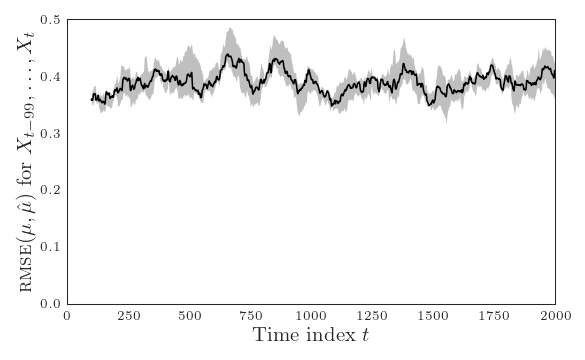

In [81]:
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.fill_between(
    observation_time_indices[window_size - 1:], 
    np.min(rmse_in_mean_estimate_vs_time_index[:],  axis=-1), 
    np.max(rmse_in_mean_estimate_vs_time_index[:],  axis=-1), 
    alpha=0.5,
    facecolor='gray',
    edgecolor='gray',
    lw=0,
)
ax.plot(
    observation_time_indices[window_size - 1:], 
    np.median(rmse_in_mean_estimate_vs_time_index[:], axis=-1),
    color='black'
)
ax.set_xlabel('Time index $t$')
ax.set_ylabel(f'$\\textsc{{rmse}}(\\mu,\\hat{{\\mu}})$ for $X_{{t-{window_size - 1}}},\\dots,X_{{t}}$')
ax.set_ylim(0, 0.5)
ax.set_xlim(0, 2000)
fig.tight_layout()
fig.savefig('damped-advection-model-time-stability.pdf')